In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import pickle
import scipy.signal
import glob
# import cv2
from skimage.exposure import rescale_intensity
import argparse
from sklearn.cluster import KMeans
from itertools import groupby
from skimage import color, data, restoration
import h5py
import random
from tqdm import tqdm
import os
import time
from patchify import patchify, unpatchify
import glob
import tensorflow

from keras import layers
from keras.datasets import mnist
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping

/home/ar0535/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ar0535/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ar0535/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ar0535/.conda/envs/tfgpu/lib/python3.6/site-packages

In [2]:
model = load_model('/scratch/gpfs/ar0535/spec_model_data/sweep_3layer/best_model')

In [42]:
def display(Sxx, final, dset):
    n = 2
    
    t = np.array(dset['t'])[:3840]
    f = (np.array(dset['f'])/1000)+1
    
    idx = np.random.randint(len(Sxx), size=n)
    plots1 = Sxx[idx, :]
    plots2 = final[idx, :]
    
    fig = plt.figure(figsize=(8,12))
    grd = gridspec.GridSpec(ncols=1, nrows=(2 * n), figure=fig)
    ax=[None] * (2 * n)
    
    for i, (plot1, plot2) in enumerate(zip(plots1, plots2)):
        ax[2*i] = fig.add_subplot(grd[2*i])
        ax[2*i].pcolormesh(t,f,plot1,cmap='hot',shading='gouraud')
        _=plt.ylabel('Original (kHz)')
        
        ax[2*i+1] = fig.add_subplot(grd[2*i+1])
        ax[2*i+1].pcolormesh(t,f,plot2,cmap='hot',shading='gouraud')
        _=plt.ylabel('Final (kHz)')
    
    plt.plot()

In [3]:
file = h5py.File('/scratch/gpfs/ar0535/spectrogram_data.hdf5', 'r')
shotn = 176053
dset = file[f'ece_{shotn}']['chn_1']

In [7]:
len(list(file.keys()))

1138

In [6]:
dset['f'][-1]/1000

249.0234375

In [79]:
# predict and reformat
Sxx_test_reshaped = reshape(Sxx_train)

# Remove lowest 5 frequency points
for i in range(len(Sxx_test_reshaped[:,0,0,0])):
    for j in range(len(Sxx_test_reshaped[0,0,:,0])):
        for k in range(5):
            Sxx_test_reshaped[i,k,j,0] = 0.0

predictions = model.predict(Sxx_test_reshaped)
predictions = np.squeeze(predictions, axis=3)

# restitch everything together to a list of spectrograms
noisy = unpatch(Sxx_train)
autoencoder_final = unpatch(predictions)

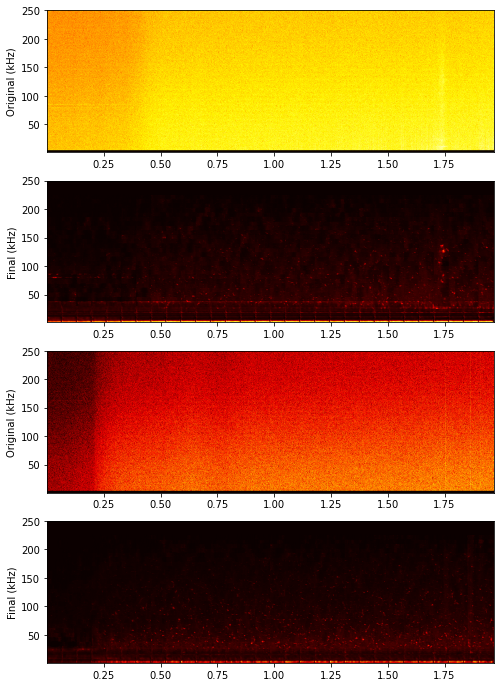

In [80]:
display(noisy, autoencoder_final, dset)

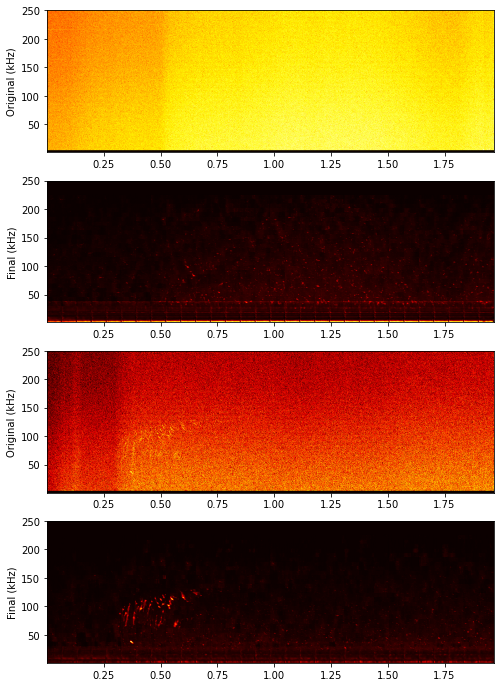

In [81]:
display(noisy, autoencoder_final, dset)

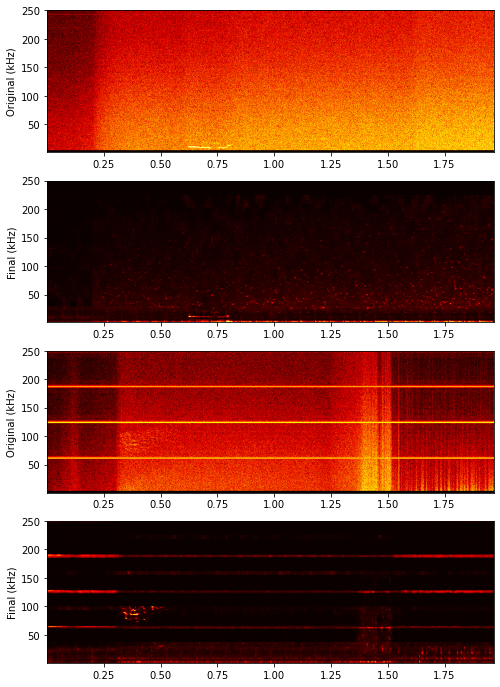

In [82]:
display(noisy, autoencoder_final, dset)

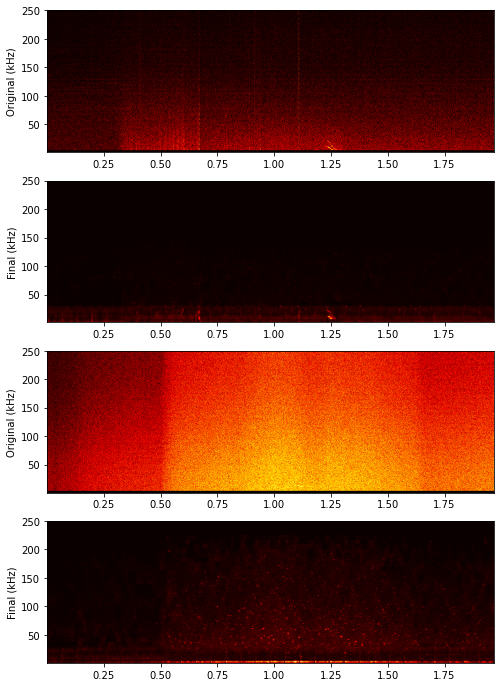

In [83]:
display(noisy, autoencoder_final, dset)

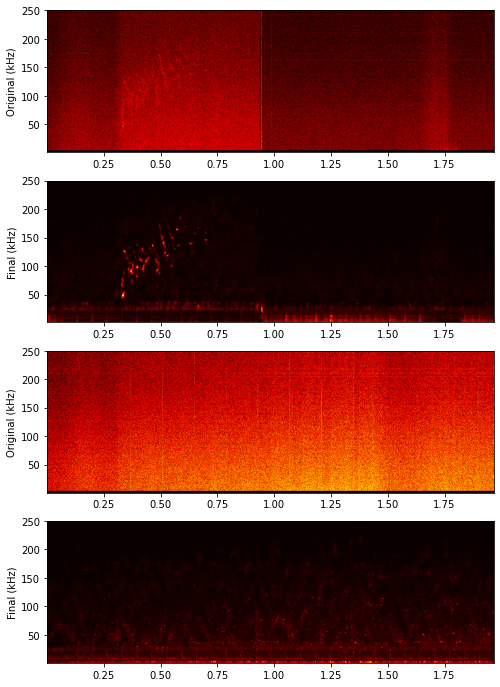

In [84]:
display(noisy, autoencoder_final, dset)

In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [3]:
# patches all the strips together to 1 spectrogram
def patch(arr):
    all_patches = np.empty((len(arr)* 30, 256, 128))
    for i in range(len(arr)):
        patches = patchify(arr[i], (256, 128), step=128)
        
        for x in range(30):
            all_patches[(x + 30 * i)] = patches[0][x]
    
    return all_patches

# splits spectrogram into strips
def unpatch(arr):
    all_spectrograms = []
    for i in range(int(len(arr) / 30)):
        Sxx = []
        for x in range(30):
            Sxx.append(arr[x + 30 * i])
        
        y=[Sxx]
        reconstructed = unpatchify(np.array(y), (256, 3840))
        all_spectrograms.append(reconstructed)
    return np.array(all_spectrograms)

#reshapes the data
def reshape(arr):
    arr = np.reshape(arr, (len(arr), 256, 128, 1))
    return arr

In [54]:
spectrograms = []
final = []
thr = 0.9

file = h5py.File('/scratch/gpfs/ar0535/spectrogram_data.hdf5', 'r')

num_samples = 50
random_sample = random.sample(file.keys(), num_samples)

for fname in tqdm(random_sample):
    shotn = fname[fname.rfind('_')+1:fname.rfind('.')]

    for chn in range(20):
        name = fname+'/chn_'+str(chn+1)
        spectrograms.append(np.array(file[name]['spec']))     
        final.append(np.array(file[name]['pipeline_out']))

# Change shape so that time length is 128 points
spectrograms = patch(spectrograms)
final = patch(final)

#split into 60% (train), 25% (tune), 15% (test)
Sxx_train, Sxx_tune, Sxx_test = np.split(spectrograms, [int(len(spectrograms)*0.6), int(len(spectrograms)*0.85)])
final_train, final_tune, final_test = np.split(final, [int(len(final)*0.6), int(len(final)*0.85)])

100%|██████████| 50/50 [01:26<00:00,  1.74s/it]


In [22]:
np.shape(spectrograms)

(12000, 256, 128)

In [21]:
print(np.shape(final_train)[0]*5)
print(np.shape(final_tune)[0]*5)
print(np.shape(final_test)[0]*5)

36000
15000
9000


In [32]:
# Initialize network
input = layers.Input(shape = (256, 128, 1))

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 128, 1)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 128, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 64, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 64, 32)       9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 16, 32)        0         
__________

In [33]:
# reshape our data to add 1 extra dim for pooling later
Sxx_train_reshaped = reshape(Sxx_train)
Sxx_test_reshaped = reshape(Sxx_test)
Sxx_tune_reshaped = reshape(Sxx_tune)
final_train_reshaped = reshape(final_train)
final_test_reshaped = reshape(final_test)
final_tune_reshaped = reshape(final_tune)

In [38]:
ep = 40 # Epochs, 10 may be too few but 100 was overkill
hist = autoencoder.fit(
    x=Sxx_train_reshaped,
    y=final_train_reshaped,
    epochs=ep,
    batch_size=128,
    shuffle=True,
    validation_data=(Sxx_tune_reshaped, final_tune_reshaped),
    callbacks=[es],
)

Train on 7200 samples, validate on 3000 samples
Epoch 1/40
7200/7200 [==============================] - 9s 1ms/step - loss: 0.1006 - val_loss: 0.1125
Epoch 2/40
7200/7200 [==============================] - 9s 1ms/step - loss: 0.1004 - val_loss: 0.1134
Epoch 3/40
7200/7200 [==============================] - 9s 1ms/step - loss: 0.1002 - val_loss: 0.1131
Epoch 4/40
7200/7200 [==============================] - 9s 1ms/step - loss: 0.1001 - val_loss: 0.1145
Epoch 5/40
7200/7200 [==============================] - 9s 1ms/step - loss: 0.1001 - val_loss: 0.1136
Epoch 00005: early stopping


In [29]:
hist.history['val_loss']

[0.1414703220129013,
 0.11503374616305033,
 0.11373697896798451,
 0.11372168509165446,
 0.11316988261540731,
 0.11308167616526286,
 0.11303127427895863,
 0.11182338907321294,
 0.11255127052466074,
 0.11144744634628295]

In [8]:
print(hist.history)

{'val_loss': [0.1414703220129013, 0.11503374616305033, 0.11373697896798451, 0.11372168509165446, 0.11316988261540731, 0.11308167616526286, 0.11303127427895863, 0.11182338907321294, 0.11255127052466074, 0.11144744634628295], 'loss': [0.2972241630156835, 0.11323306752575768, 0.104883624513944, 0.1043971500131819, 0.10420053750276566, 0.1039418880144755, 0.10372559262646569, 0.1032941590415107, 0.10304736031426323, 0.1029316622349951]}


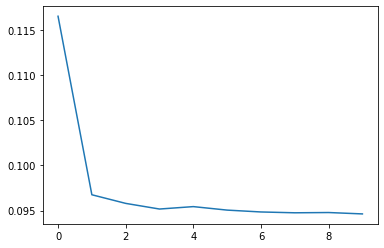

In [8]:
plt.plot(range(ep), hist.history['val_loss'])

In [14]:
file = h5py.File('/scratch/gpfs/ar0535/spectrogram_data.hdf5', 'r')

In [26]:
shotn = 176053 # Shot we decide to look at
dset = file[f'ece_{shotn}'][f'chn_{4}']

In [27]:
noisy = []
noisy.append(np.array(dset['spec']))
noisy = patch(noisy)

In [28]:
np.shape(noisy)[0]

30

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import pickle
import scipy.signal
import glob
import cv2
from skimage.exposure import rescale_intensity
import argparse
from sklearn.cluster import KMeans
from itertools import groupby
from skimage import color, data, restoration
import h5py
import random
from tqdm import tqdm
import os
import time
from patchify import patchify, unpatchify
import glob
import tensorflow

from keras import layers
from keras.datasets import mnist
from keras.models import Model
from keras.models import load_model

# patches all the strips together to 1 spectrogram
def patch(arr):
    all_patches = np.empty((len(arr)* 30, 256, 128))
    for i in range(len(arr)):
        patches = patchify(arr[i], (256, 128), step=128)
        
        for x in range(30):
            all_patches[(x + 30 * i)] = patches[0][x]
    
    return all_patches

# splits spectrogram into strips
def unpatch(arr):
    all_spectrograms = []
    for i in range(int(len(arr) / 30)):
        Sxx = []
        for x in range(30):
            Sxx.append(arr[x + 30 * i])
        
        y=[Sxx]
        reconstructed = unpatchify(np.array(y), (256, 3840))
        all_spectrograms.append(reconstructed)
    return np.array(all_spectrograms)

#reshapes the data
def reshape(arr):
    arr = np.reshape(arr, (len(arr), 256, 128, 1))
    return arr

# displays Sxx and final
def display(Sxx, final, fname, dset):
    n = 3
    
    t = np.array(dset['t'])[:3840]
    f = (np.array(dset['f'])/1000)+1
    
    idx = np.random.randint(len(Sxx), size=n)
    plots1 = Sxx[idx, :]
    plots2 = final[idx, :]
    
    fig = plt.figure(figsize=(8,12))
    grd = gridspec.GridSpec(ncols=1, nrows=(2 * n), figure=fig)
    ax=[None] * (2 * n)
    
    for i, (plot1, plot2) in enumerate(zip(plots1, plots2)):
        ax[2*i] = fig.add_subplot(grd[2*i])
        ax[2*i].pcolormesh(t,f,plot1,cmap='hot',shading='gouraud')
        _=plt.ylabel('Original (kHz)')
        
        ax[2*i+1] = fig.add_subplot(grd[2*i+1])
        ax[2*i+1].pcolormesh(t,f,plot2,cmap='hot',shading='gouraud')
        _=plt.ylabel('Final (kHz)')
    
    plt.savefig(fname)
    
def plt_spec_shot(dset, predictions, noisy, shotn, i, plot_name):
    # Read data from hdf5 file and change shape of raw spectrogram
    pipeline = []
    pipeline.append(np.array(dset['pipeline_out']))

    # Change shape of predictions and processed data for viewing
    predictions = np.squeeze(predictions, axis=3)
    noisy = unpatch(noisy)[0,:,:]
    predictions = unpatch(predictions)[0,:,:]
    processed = unpatch(patch(pipeline))[0,:,:]
    
    t = np.array(dset['t'])[:3840]
    f = (np.array(dset['f'])/1000)+1
    
    # Make plot 
    fig = plt.figure(figsize=(8,12))
    grd = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
    ax=[None] * 3
    caption = 'shot# %s, channel %i' % (shotn, i)
    
    ax[0] = fig.add_subplot(grd[0])
    ax[0].pcolormesh(t,f,noisy,cmap='hot',shading='gouraud')
    _=plt.ylabel('Original - Raw Data (kHz))')
    ax[0].set(title=caption)

    ax[1] = fig.add_subplot(grd[1])
    ax[1].pcolormesh(t,f,predictions,cmap='hot',shading='gouraud')
    _=plt.ylabel('Predicted Denoised (kHz)')
    
    ax[2] = fig.add_subplot(grd[2])
    ax[2].pcolormesh(t,f,processed,cmap='hot',shading='gouraud')
    _=plt.ylabel('Pipeline (kHz)')
    
    plt.savefig(plot_name)

In [2]:
# Get job array ID to use when running hyperparam sweep
# idx = int(os.environ["SLURM_ARRAY_TASK_ID"])
idx = 1
kernel_vals = [(1,1), (3,3), (5,5), (7,7), (9,9)]

spectrograms = []
final = []
thr = 0.9

file = h5py.File('/scratch/gpfs/ar0535/spectrogram_data.hdf5', 'r')

num_samples = 10
random_sample = random.sample(file.keys(), num_samples)

for fname in tqdm(random_sample):
    shotn = fname[fname.rfind('_')+1:fname.rfind('.')]

    for chn in range(20):
        name = fname+'/chn_'+str(chn+1)
        spectrograms.append(np.array(file[name]['spec']))     
        final.append(np.array(file[name]['pipeline_out']))

# Change shape so that time length is 128 points
spectrograms = patch(spectrograms)
final = patch(final)

#split into 60% (train), 25% (tune), 15% (test)
Sxx_train, Sxx_tune, Sxx_test = np.split(spectrograms, [int(len(spectrograms)*0.6), int(len(spectrograms)*0.85)])
final_train, final_tune, final_test = np.split(final, [int(len(final)*0.6), int(len(final)*0.85)])

# Initialize network
input = layers.Input(shape = (256, 128, 1))

x = layers.Conv2D(32, kernel_vals[idx], activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, kernel_vals[idx], activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

x = layers.Conv2DTranspose(32, kernel_vals[idx], strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, kernel_vals[idx], strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, kernel_vals[idx], activation="sigmoid", padding="same")(x)

autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
# autoencoder.summary()

# reshape our data to add 1 extra dim for pooling later
Sxx_train_reshaped = reshape(Sxx_train)
Sxx_test_reshaped = reshape(Sxx_test)
Sxx_tune_reshaped = reshape(Sxx_tune)
final_train_reshaped = reshape(final_train)
final_test_reshaped = reshape(final_test)
final_tune_reshaped = reshape(final_tune)

ep = 5 # Epochs, 10 may be too few but 100 was overkill
hist = autoencoder.fit(
    x=Sxx_train_reshaped,
    y=final_train_reshaped,
    epochs=ep,
    batch_size=128,
    shuffle=True,
    validation_data=(Sxx_tune_reshaped, final_tune_reshaped),
)

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Train on 3600 samples, validate on 1500 samples
Epoch 1/5
3600/3600 [==============================] - 148s 41ms/step - loss: 0.4107 - val_loss: 0.2577
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.1467 - val_loss: 0.1698
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.1262 - val_loss: 0.1495
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.1110 - val_loss: 0.1316
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.1024 - val_loss: 0.1283


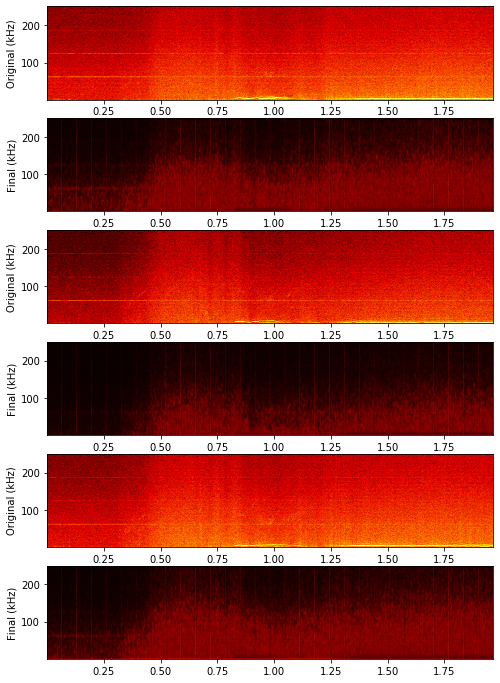

In [6]:
# predict and reformat
predictions = autoencoder.predict(Sxx_test_reshaped)
predictions = np.squeeze(predictions, axis=3)

# restitch everything together to a list of spectrograms
noisy = unpatch(Sxx_test)
autoencoder_final = unpatch(predictions)
pipeline_final = unpatch(final_test)

data_path = f'/scratch/gpfs/ar0535/spec_model_data/kernel_{kernel_vals[idx][0]}/'
os.makedirs(data_path)

# Sample data set for general time and freq data (axis for plotting)
shotn = 176053 # Shot we decide to look at
dset = file[f'ece_{shotn}']['chn_1']
display(noisy, autoencoder_final, data_path+'ex_specs.png', dset)

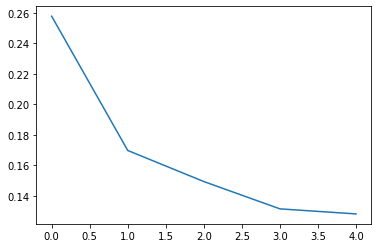

In [8]:
# Save validation loss and validation loss plot
val_loss = hist.history['val_loss']
plt.plot(range(ep), val_loss)
plt.savefig(data_path+'val_loss.png')
np.savetxt(data_path+'val_loss.txt', val_loss)

ValueError: Expected 1D or 2D array, got 0D array instead

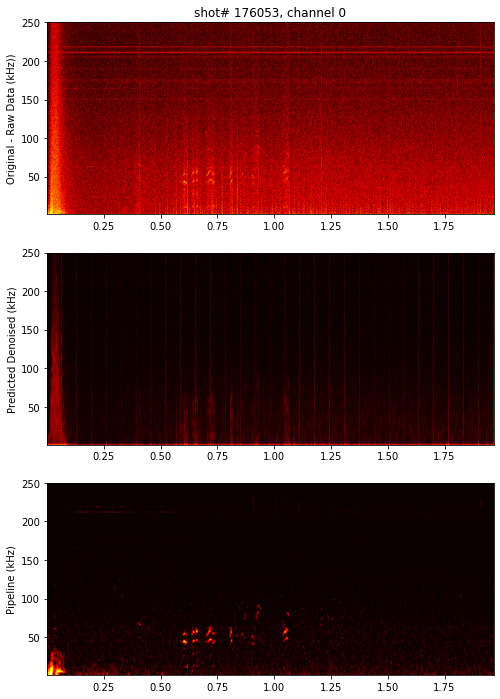

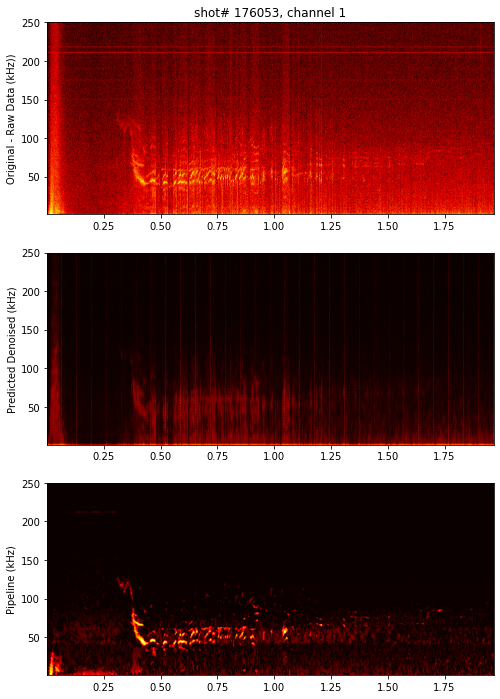

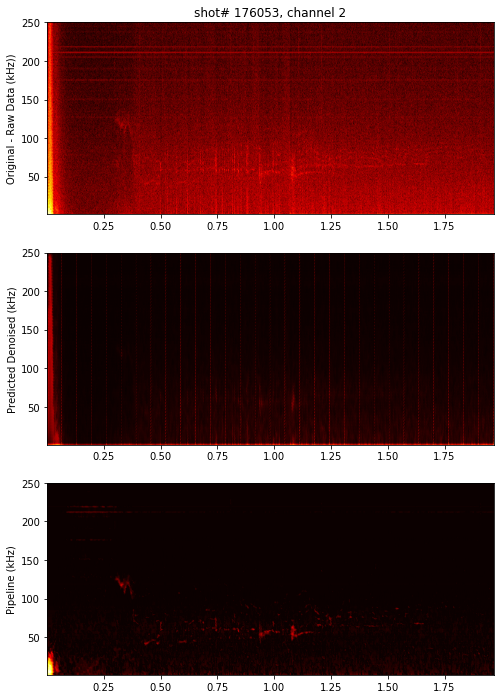

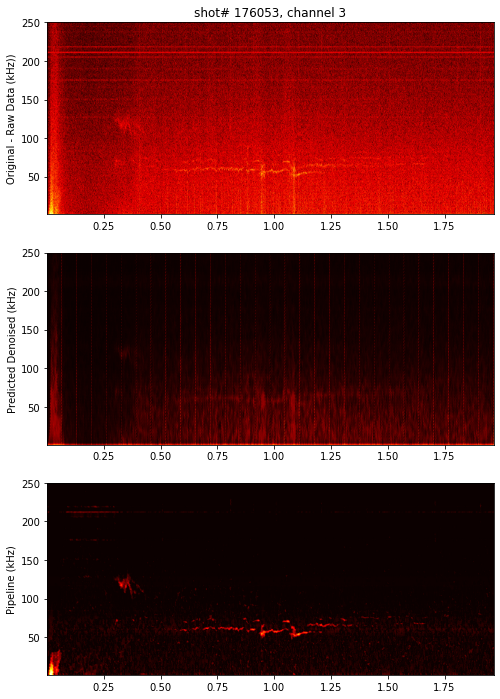

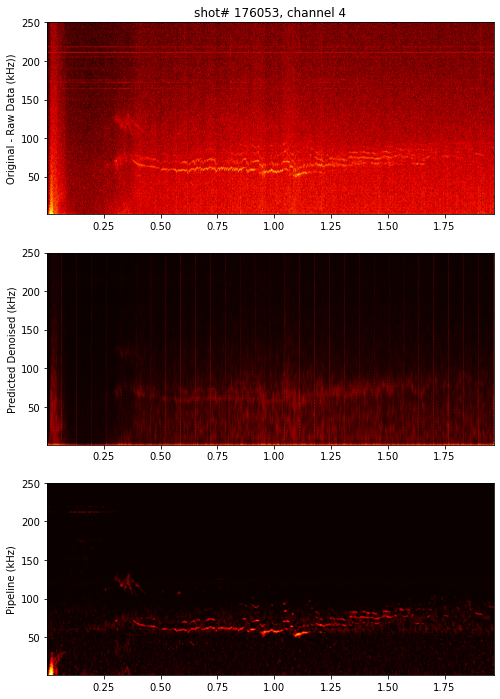

Error in callback <function flush_figures at 0x20023ccdf7b8> (for post_execute):


KeyboardInterrupt: 

In [17]:
t_predict = 0.0
chn_num = 20 # Total channel number
# Example prediction plot
for i in range(chn_num):
    # Load specific channel data
    dset = file[f'ece_{shotn}'][f'chn_{i+1}']

    # Read raw data from hdf5 file and change shape of raw spectrogram
    noisy = []
    noisy.append(np.array(dset['spec']))
    noisy = patch(noisy)

    # Time autoencoder predictions
    start = time.time()
    predictions = autoencoder.predict(reshape(noisy))
    end = time.time()

    # Plot raw, processed, and predicted spectrograms
    if (i+1) in range(10,13):
        plt_spec_shot(dset, predictions, noisy, shotn, i, data_path+f'plot_chn_{i+1}.png')

    # Add prediction time to running total
    t_predict += (end-start)


# Time to get prediction
t_predict /= chn_num
np.savetxt(data_path+'t_pred.txt', np.array(t_predict))

In [26]:
# Save Autoencoder
autoencoder.save(data_path+'keras_model')

file.close()

In [37]:
f = h5py.File('/scratch/gpfs/ar0535/spectrogram_data.hdf5', 'r')

In [38]:
pipeline = np.array(f['ece_176053']['chn_1']['pipeline_out'])
spec = np.array(f['ece_176053']['chn_1']['spec'])

In [39]:
spectrograms = []
final = []

for chn in range(10,13):
    spectrograms.append(np.array(f['ece_176053']['chn_1']['spec']))     
    final.append(np.array(f['ece_176053']['chn_1']['pipeline_out']))

In [42]:
spectrograms = patch(spectrograms)
final = patch(final)

In [43]:
def plt_spec_shot(dset, noisy, shotn, i):
    # Read data from hdf5 file and change shape of raw spectrogram
    pipeline = []
    pipeline.append(np.array(dset['pipeline_out']))

    # Change shape of predictions and processed data for viewing
    noisy = unpatch(noisy)[0,:,:]
    processed = unpatch(patch(pipeline))[0,:,:]
    
    t = np.array(dset['t'])[:3840]
    f = (np.array(dset['f'])/1000)+1
    
    fst = 24
    fs = 18
    
    # Make plot 
    fig = plt.figure(figsize=(8,12))
    grd = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
    ax=[None] * 2
    caption = 'shot# %s, channel %i' % (shotn, i)
    
    ax[0] = fig.add_subplot(grd[0])
    ax[0].pcolormesh(t,f,noisy,cmap='hot',shading='gouraud')
    _=plt.ylabel('Original - Raw Data (kHz))', fontsize=fs)
    # ax[0].set(title=caption)
    plt.title(caption, fontsize=fst)
    
    ax[1] = fig.add_subplot(grd[1])
    ax[1].pcolormesh(t,f,processed,cmap='hot',shading='gouraud')
    _=plt.ylabel('Pipeline (kHz)', fontsize=fs)
    
    # plt.show()
    plt.savefig('/home/ar0535/APS_figs/nofeature_spec.png')

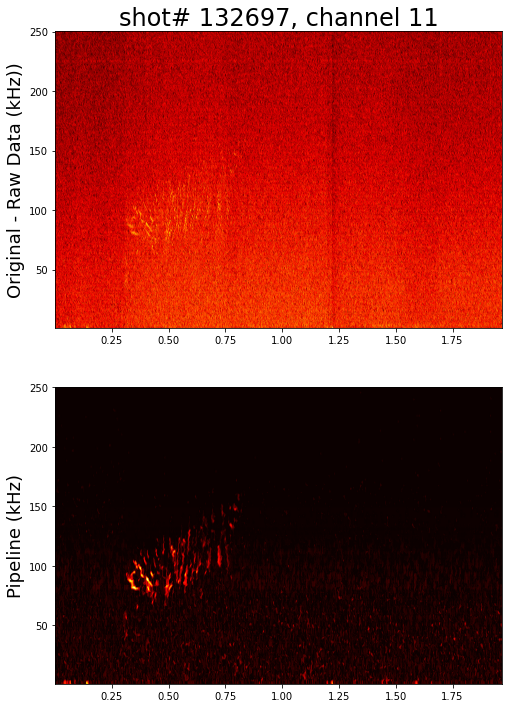

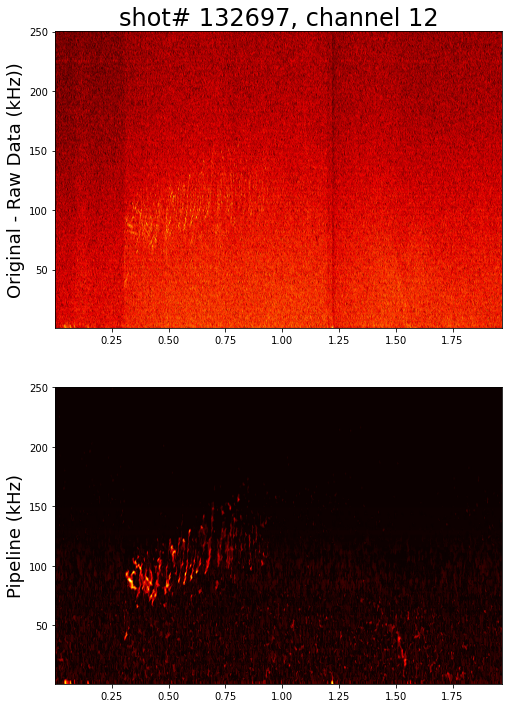

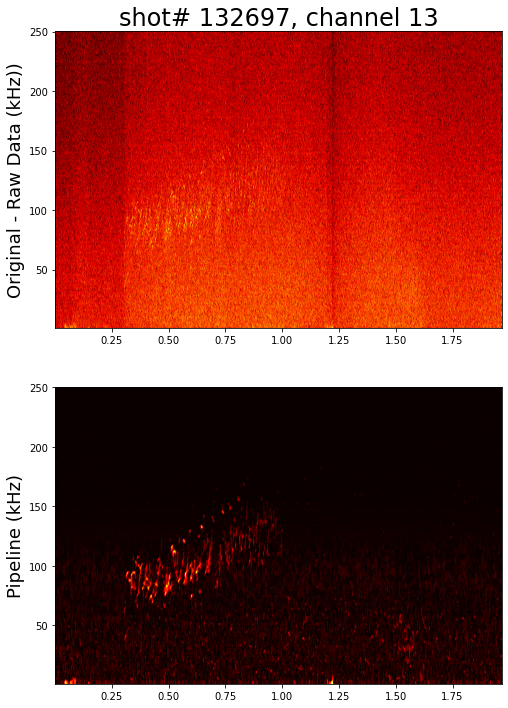

In [51]:
shotn = 132697
# shotn = 176053
for i in range(11,14):
        # Load specific channel data
        dset = f[f'ece_{shotn}'][f'chn_{i}']

        # Read raw data from hdf5 file and change shape of raw spectrogram
        noisy = []
        noisy.append(np.array(dset['spec']))
        noisy = patch(noisy)

        # Plot raw, processed, and predicted spectrograms
        plt_spec_shot(dset, noisy, shotn, i)

In [46]:
list(f.keys())

['ece_122117',
 'ece_132215',
 'ece_132216',
 'ece_132217',
 'ece_132218',
 'ece_132219',
 'ece_132220',
 'ece_132221',
 'ece_132222',
 'ece_132223',
 'ece_132224',
 'ece_132225',
 'ece_132226',
 'ece_132227',
 'ece_132228',
 'ece_132229',
 'ece_132230',
 'ece_132231',
 'ece_132232',
 'ece_132233',
 'ece_132234',
 'ece_132235',
 'ece_132236',
 'ece_132237',
 'ece_132238',
 'ece_132239',
 'ece_132240',
 'ece_132591',
 'ece_132592',
 'ece_132593',
 'ece_132594',
 'ece_132595',
 'ece_132596',
 'ece_132597',
 'ece_132598',
 'ece_132599',
 'ece_132600',
 'ece_132601',
 'ece_132602',
 'ece_132603',
 'ece_132604',
 'ece_132605',
 'ece_132606',
 'ece_132607',
 'ece_132608',
 'ece_132609',
 'ece_132611',
 'ece_132612',
 'ece_132614',
 'ece_132615',
 'ece_132616',
 'ece_132696',
 'ece_132697',
 'ece_132698',
 'ece_132699',
 'ece_132700',
 'ece_132701',
 'ece_132702',
 'ece_132703',
 'ece_132704',
 'ece_132705',
 'ece_132706',
 'ece_132707',
 'ece_132708',
 'ece_132709',
 'ece_132710',
 'ece_1327

In [29]:
model = load_model('best_model')

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 256, 128, 1)       0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 256, 128, 32)      832       
_________________________________________________________________
max_pooling2d_133 (MaxPoolin (None, 128, 64, 32)       0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 128, 64, 64)       51264     
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 64, 32, 64)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 64, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 32, 16, 64)        0         
__________

In [35]:
model.get_layer('conv2d_179').filters

64